# Model South Korea Time Series for COVID : Training

This notebook creates a LSTM Tensorflow model to predict confirmed covid-19 cases in South Korea.  
It retrieves data from Korean gouvernment, explores features, creates & trains model.  

Not in this notebook : 
- This model will be converted into Tensorflow Lite here :
ModelCovidTimeSeries-convert-publish-KR.ipynb 
- It will be use in a serverless AWS Lambda function to predict confirmed cases for my web app [app-covid-visu](http://app-covid-visu.coolplace.fr/) 
 
The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input). 

**Input Features are daily data of:**

- Min/Max Temperatures
- Mean Humidities
- Mean Wind speed
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Confirmed cases

**DATA sources:**

- Tested / Confirmed cases KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043376
- Confirmed cases by age KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043377
- Confirmed cases by area KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043378
- Meteo South Korea (Seoul, Deagu, Busan): https://www.visualcrossing.com/weather-data


**GitHub:** https://github.com/jeugregg/coronavirusModel

## Settings notebook

In [2]:
mode_collect = False # True : retrieve data online (set TRAIN_SPLIT in model_kr)
mode_train = True # True : Train model

## import

In [3]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
import settings
from my_helpers.data_plots_kr import update_df_feat_kr
from my_helpers.data_plots_kr import load_df_feat_kr

from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

from my_helpers.dates import add_days
from my_helpers.dates import generate_list_dates

from my_helpers.model_kr import prepare_data_features_kr
from my_helpers.model_kr import prepare_dataset_kr

In [4]:
tf.__version__ 

'2.5.0'

## Definitions

In [5]:
#PATH_DF_FEAT_KR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_TO_SAVE_DATA = settings.PATH_TO_SAVE_DATA
from my_helpers.model_kr import PATH_MDL_MULTI_STEP_KR
#PATH_MDL_MULTI_STEP_KR = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_kr"

#PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
#    'serverless/tensorflow_lite_on_aws_lambda'
#PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
#    "converted_model.tflite"
#PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

#date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
#NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

#URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
from my_helpers.model_kr import PAST_HISTORY # days used to predict next values in future
from my_helpers.model_kr import FUTURE_TARGET  # predict 3 days later
from my_helpers.model_kr import STEP 


##  Helper functions

In [6]:
# FOR MODEL
# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()



def prepare_data_features_kr_old(df_feat_kr):
    df_out = df_feat_kr.copy().filter(items=["date", 'nb_cases', 
                                             'T_min', 'T_max', 'H_mean',
                                           'W_speed', 'pos', 'test', 'day_num',
                                           'age_pos'])
    df_out.fillna(method="pad", inplace=True)
    df_out.dropna(inplace=True)
    date_old = add_days(df_out.index[0].strftime("%Y-%m-%d"), -1)
    dates_index =  df_out.index.strftime("%Y-%m-%d")
    for date_curr in dates_index:
        if date_curr != add_days(date_old, 1):
            print("ERROR : ", date_curr)
            #break
        assert date_curr == add_days(date_old, 1)
        date_old = date_curr
    return df_out

## Retrieve data

In [7]:
if mode_collect:
    df_feat_kr = update_df_feat_kr()
    df_feat_kr

## Reload data

In [8]:
df_feat_kr = load_df_feat_kr()
df_feat_kr

nb_cases    nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                     
2020-02-02       2.0         0.0        2.0  2020-02-02      0.0   NaN   
2020-02-03      15.0         0.0        0.0  2020-02-03      1.0   NaN   
2020-02-04       0.0         0.0        0.0  2020-02-04      2.0   NaN   
2020-02-05      19.0         0.0        0.0  2020-02-05      3.0   NaN   
2020-02-06      23.0         0.0        0.0  2020-02-06      4.0   NaN   
...              ...         ...        ...         ...      ...   ...   
2021-06-18  150238.0  10168211.0     1996.0  2021-06-18      5.0   6.0   
2021-06-19  150720.0  10194433.0     1997.0  2021-06-19      6.0   7.0   
2021-06-20  151149.0  10204572.0     2002.0  2021-06-20      0.0   2.0   
2021-06-21  151506.0  10217614.0     2004.0  2021-06-21      1.0   3.0   
2021-06-22  151901.0  10252916.0     2006.0  2021-06-22      2.0   1.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  sum_Jeonbuk  \
date                                                ...                
2020-02-02        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-03        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-04        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-05        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-06        NaN        NaN      NaN      NaN  ...          NaN   
...               ...        ...      ...      ...  ...          ...   
2021-06-18       14.0       11.0      4.0      4.0  ...         55.0   
2021-06-19       11.0        4.0      5.0      5.0  ...         46.0   
2021-06-20       11.0        6.0      3.0      3.0  ...         49.0   
2021-06-21       13.0        8.0     10.0      3.0  ...         49.0   
2021-06-22       11.0       11.0      8.0      2.0  ...         47.0   

            Rt_Jeonbuk  sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                                           
2020-02-02         NaN          NaN         NaN            NaN           NaN   
2020-02-03         NaN          NaN         NaN            NaN           NaN   
2020-02-04         NaN          NaN         NaN            NaN           NaN   
2020-02-05         NaN          NaN         NaN            NaN           NaN   
2020-02-06         NaN          NaN         NaN            NaN           NaN   
...                ...          ...         ...            ...           ...   
2021-06-18    0.528846         81.0    0.618321          104.0      0.611765   
2021-06-19    0.433962         72.0    0.558140           98.0      0.597561   
2021-06-20    0.532609         66.0    0.515625           94.0      0.580247   
2021-06-21    0.538462         73.0    0.623932           93.0      0.584906   
2021-06-22    0.522222         73.0    0.618644           97.0      0.629870   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  
date                                                         
2020-02-02            NaN           NaN       NaN       NaN  
2020-02-03            NaN           NaN       NaN       NaN  
2020-02-04            NaN           NaN       NaN       NaN  
2020-02-05            NaN           NaN       NaN       NaN  
2020-02-06            NaN           NaN       NaN       NaN  
...                   ...           ...       ...       ...  
2021-06-18          280.0      1.037037     132.0  0.745763  
2021-06-19          271.0      1.007435     117.0  0.609375  
2021-06-20          265.0      0.985130     100.0  0.492611  
2021-06-21          250.0      0.892857      90.0  0.456853  
2021-06-22          213.0      0.678344      83.0  0.441489  

[507 rows x 87 columns]

In [9]:
df_feat_kr.filter(items=["date", 'T_min', 'T_max', 'H_mean',
    'pos', 'test', 'day_num', 'age_pos', 
    'W_mean'])[df_feat_kr["date"] >= "2020-04-03"].head()

date     T_min      T_max     H_mean   pos     test  \
date                                                                    
2020-04-03  2020-04-03  5.233333  18.833333  46.640000  86.0  10507.0   
2020-04-04  2020-04-04  5.266667  18.000000  44.216667  94.0  10523.0   
2020-04-05  2020-04-05  2.633333  14.733333  36.973333  81.0   6774.0   
2020-04-06  2020-04-06  2.133333  16.633333  44.676667  47.0   5847.0   
2020-04-07  2020-04-07  6.900000  19.600000  47.673333  47.0   9145.0   

            day_num    age_pos  
date                            
2020-04-03      5.0  41.898165  
2020-04-04      6.0  41.898165  
2020-04-05      0.0  41.898165  
2020-04-06      1.0  41.898165  
2020-04-07      2.0  41.898165

In [10]:
df_feat_kr.filter(items=["date", 'T_min', 'T_max', 'H_mean',
    'pos', 'test', 'day_num', 'age_pos', 
    'W_speed'])[df_feat_kr["date"] >= "2020-06-10"].head()

date      T_min      T_max     H_mean   pos     test  \
date                                                                     
2020-06-10  2020-06-10  20.566667  32.766667  58.493333  50.0  17211.0   
2020-06-11  2020-06-11  21.633333  30.233333  75.713333  45.0  15645.0   
2020-06-12  2020-06-12  21.266667  29.033333  76.100000  56.0  15849.0   
2020-06-13  2020-06-13  20.733333  29.400000  73.890000  48.0  14109.0   
2020-06-14  2020-06-14  21.933333  28.733333  78.003333  34.0   7620.0   

            day_num    age_pos    W_speed  
date                                       
2020-06-10      3.0  51.110000  19.666667  
2020-06-11      4.0  45.177778  15.500000  
2020-06-12      5.0        NaN  16.566667  
2020-06-13      6.0  52.052885  16.900000  
2020-06-14      0.0  47.750000  23.400000

## Filter good data

In [11]:
df_feat_kr = prepare_data_features_kr(df_feat_kr)

df_feat_kr[df_feat_kr["date"] >= "2020-06-10"].head()

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-06-10   11902.0  1025748.0      276.0  2020-06-10      3.0   0.0   
2020-06-11   11947.0  1041393.0      276.0  2020-06-11      4.0   0.0   
2020-06-12   12003.0  1057242.0      277.0  2020-06-12      5.0   0.0   
2020-06-13   12051.0  1071351.0      277.0  2020-06-13      6.0   0.0   
2020-06-14   12085.0  1078971.0      277.0  2020-06-14      0.0   0.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  sum_Jeonbuk  \
date                                                ...                
2020-06-10        2.0        0.0      0.0      0.0  ...          0.0   
2020-06-11        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-12        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-13        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-14        0.0        0.0      0.0      0.0  ...          0.0   

            Rt_Jeonbuk  sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                                           
2020-06-10         0.0          2.0         1.0            5.0      0.454545   
2020-06-11         0.0          2.0         2.0            4.0      0.363636   
2020-06-12         0.0          2.0         inf            4.0      0.363636   
2020-06-13         0.0          1.0         1.0            4.0      0.363636   
2020-06-14         0.0          1.0         1.0            4.0      0.363636   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju  Rt_Jeju  
date                                                        
2020-06-10            4.0           1.0       1.0      inf  
2020-06-11            4.0           1.0       1.0      inf  
2020-06-12            4.0           1.0       1.0      inf  
2020-06-13            4.0           1.0       1.0      inf  
2020-06-14            4.0           2.0       0.0      0.0  

[5 rows x 87 columns]

## Train/Test split

In [12]:
if mode_collect:
    # keep 20% Validation samples:
    TRAIN_SPLIT = df_feat_kr.shape[0] - (2 * FUTURE_TARGET)
    TRAIN_SPLIT = round(0.8*df_feat_kr.shape[0])
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model_kr import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 347


In [13]:
df_feat_kr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_kr.shape[0])]
df_feat_kr

nb_cases    nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                     
2020-04-03   10062.0    424365.0      174.0  2020-04-03      5.0   0.0   
2020-04-04   10156.0    434888.0      177.0  2020-04-04      6.0   0.0   
2020-04-05   10237.0    441662.0      183.0  2020-04-05      0.0   3.0   
2020-04-06   10284.0    447509.0      186.0  2020-04-06      1.0   0.0   
2020-04-07   10331.0    456654.0      192.0  2020-04-07      2.0   0.0   
...              ...         ...        ...         ...      ...   ...   
2021-06-18  150238.0  10168211.0     1996.0  2021-06-18      5.0   6.0   
2021-06-19  150720.0  10194433.0     1997.0  2021-06-19      6.0   7.0   
2021-06-20  151149.0  10204572.0     2002.0  2021-06-20      0.0   2.0   
2021-06-21  151506.0  10217614.0     2004.0  2021-06-21      1.0   3.0   
2021-06-22  151901.0  10252916.0     2006.0  2021-06-22      2.0   1.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2020-04-03        1.0        5.0      1.0      1.0  ...    5.000000   
2020-04-04        1.0        1.0      0.0      0.0  ...    5.000000   
2020-04-05        1.0        4.0      0.0      1.0  ...    6.000000   
2020-04-06        2.0        2.0      0.0      0.0  ...    6.000000   
2020-04-07        1.0        1.0      0.0      0.0  ...    6.000000   
...               ...        ...      ...      ...  ...         ...   
2021-06-18       14.0       11.0      4.0      4.0  ...    0.528846   
2021-06-19       11.0        4.0      5.0      5.0  ...    0.433962   
2021-06-20       11.0        6.0      3.0      3.0  ...    0.532609   
2021-06-21       13.0        8.0     10.0      3.0  ...    0.538462   
2021-06-22       11.0       11.0      8.0      2.0  ...    0.522222   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2020-04-03         10.0         inf          106.0      4.240000   
2020-04-04         10.0         inf           67.0      1.030769   
2020-04-05          9.0    9.000000           60.0      0.789474   
2020-04-06          9.0    9.000000           60.0      0.769231   
2020-04-07          9.0    9.000000           60.0      0.759494   
...                 ...         ...            ...           ...   
2021-06-18         81.0    0.618321          104.0      0.611765   
2021-06-19         72.0    0.558140           98.0      0.597561   
2021-06-20         66.0    0.515625           94.0      0.580247   
2021-06-21         73.0    0.623932           93.0      0.584906   
2021-06-22         73.0    0.618644           97.0      0.629870   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2020-04-03           20.0     20.000000       5.0       inf   True  
2020-04-04           21.0     21.000000       5.0       inf   True  
2020-04-05           21.0     10.500000       8.0       inf   True  
2020-04-06           22.0      7.333333       8.0       inf   True  
2020-04-07           22.0      5.500000       8.0       inf   True  
...                   ...           ...       ...       ...    ...  
2021-06-18          280.0      1.037037     132.0  0.745763  False  
2021-06-19          271.0      1.007435     117.0  0.609375  False  
2021-06-20          265.0      0.985130     100.0  0.492611  False  
2021-06-21          250.0      0.892857      90.0  0.456853  False  
2021-06-22          213.0      0.678344      83.0  0.441489  False  

[446 rows x 88 columns]

In [14]:
df_feat_kr[df_feat_kr["train"] == False].head(5)

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2021-03-17   96839.0  7088038.0     1686.0  2021-03-17      3.0   1.0   
2021-03-18   97284.0  7128355.0     1688.0  2021-03-18      4.0   2.0   
2021-03-19   97747.0  7176590.0     1690.0  2021-03-19      5.0   0.0   
2021-03-20   98194.0  7215917.0     1693.0  2021-03-20      6.0   1.0   
2021-03-21   98650.0  7234391.0     1696.0  2021-03-21      0.0   1.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2021-03-17       45.0        4.0      0.0     21.0  ...    0.767241   
2021-03-18       35.0        5.0      0.0     15.0  ...    0.844828   
2021-03-19       42.0        4.0      0.0     15.0  ...    0.948276   
2021-03-20       31.0       11.0      0.0     16.0  ...    1.089286   
2021-03-21       54.0        5.0      0.0     11.0  ...    1.174312   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2021-03-17         34.0    0.453333          102.0      0.573034   
2021-03-18         33.0    0.458333          100.0      0.617284   
2021-03-19         33.0    0.532258           98.0      0.671233   
2021-03-20         30.0    0.545455           96.0      0.685714   
2021-03-21         24.0    0.452830           88.0      0.602740   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2021-03-17          350.0      4.605263      33.0  1.064516  False  
2021-03-18          375.0      4.746835      32.0  1.103448  False  
2021-03-19          414.0      5.671233      30.0  1.071429  False  
2021-03-20          440.0      6.285714      26.0  0.838710  False  
2021-03-21          491.0      7.439394      23.0  0.718750  False  

[5 rows x 88 columns]

### Exploration

#### Distribution of TRAIN / VALIDATION

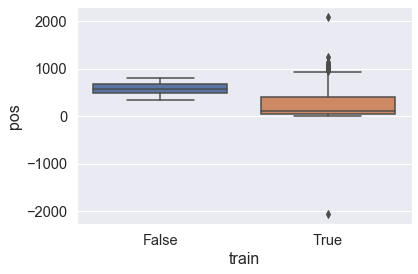

In [99]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_kr)

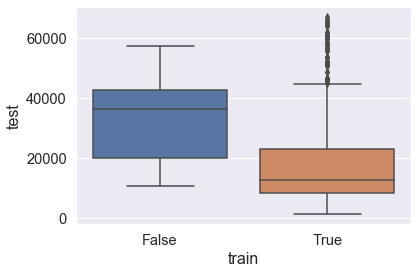

In [100]:
ax = sns.boxplot(x="train", y="test", data=df_feat_kr)

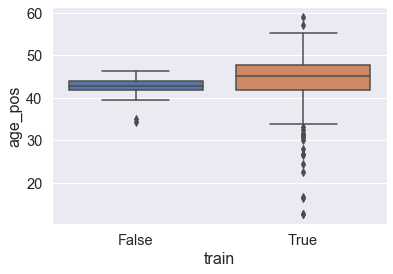

In [101]:
ax = sns.boxplot(x="train", y="age_pos", data=df_feat_kr)

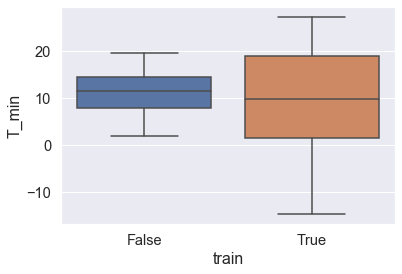

In [102]:
ax = sns.boxplot(x="train", y="T_min", data=df_feat_kr)

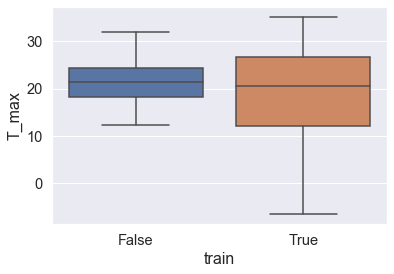

In [103]:
ax = sns.boxplot(x="train", y="T_max", data=df_feat_kr)

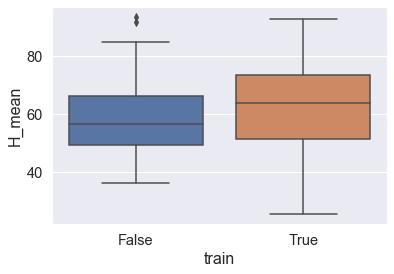

In [104]:
ax = sns.boxplot(x="train", y="H_mean", data=df_feat_kr)

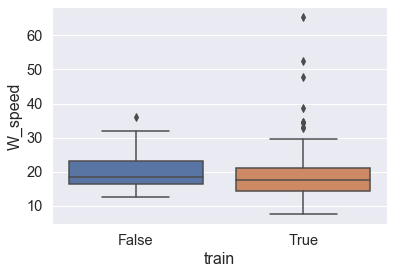

In [105]:
ax = sns.boxplot(x="train", y="W_speed", data=df_feat_kr)

#### Impact of features

In [106]:
df_tot = load_df_feat_kr()

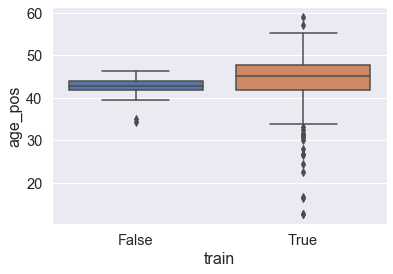

In [107]:
ax = sns.boxplot(x="train", y="age_pos", data=df_feat_kr)

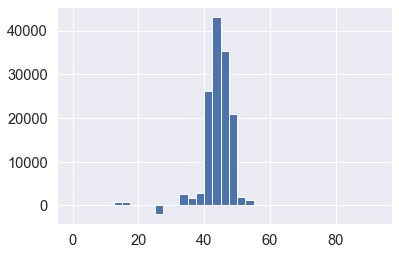

In [108]:
# data : nb pos / age_mean

# create vector ages 
plt.hist(df_tot["age_pos"], bins=np.arange(0,95, 2.5), 
         weights=df_tot["pos"], density=False);

In [109]:
list_col = ['pos_4.5', 'pos_14.5', 'pos_24.5', 'pos_34.5', 'pos_44.5',
       'pos_54.5', 'pos_64.5', 'pos_74.5', 'pos_85']
s_sum = df_tot[list_col].sum()
df_age = pd.DataFrame({'pos_age': list_col,
                   'pos': s_sum.values}, index=list_col)
def fun_extrac_age(str_in):
    re_found = re.search('(?<=pos_)[\d\.]+',str_in)
    return float(re_found[0])
df_age["age"] = df_age["pos_age"].apply(fun_extrac_age)
df_age



pos_age      pos   age
pos_4.5    pos_4.5   6392.0   4.5
pos_14.5  pos_14.5   9938.0  14.5
pos_24.5  pos_24.5  19440.0  24.5
pos_34.5  pos_34.5  19237.0  34.5
pos_44.5  pos_44.5  20952.0  44.5
pos_54.5  pos_54.5  25053.0  54.5
pos_64.5  pos_64.5  20764.0  64.5
pos_74.5  pos_74.5   9377.0  74.5
pos_85      pos_85   5364.0  85.0

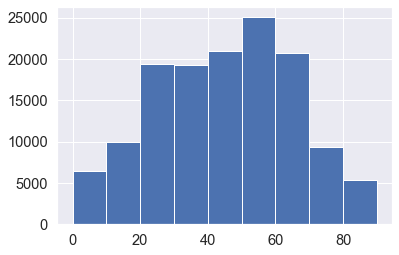

In [110]:
plt.hist(df_age["age"], bins=np.arange(0,95, 10), 
         weights=df_age["pos"], density=False);

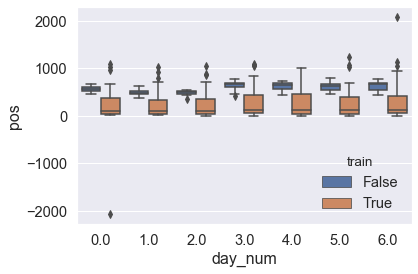

In [111]:
ax = sns.boxplot(x="day_num", y="pos", hue="train", data=df_feat_kr)

=> Hard to be confident for create a good model because train and test data are very different!

In [112]:
df_days = df_feat_kr.copy()
nb_days_week = 7

df_days['week_sin'] = np.sin(df_days["day_num"] * (2 * np.pi / nb_days_week))
df_days['week_cos'] = np.cos(df_days["day_num"] * (2 * np.pi / nb_days_week))

Text(0.5, 1.0, 'Time of week signal')

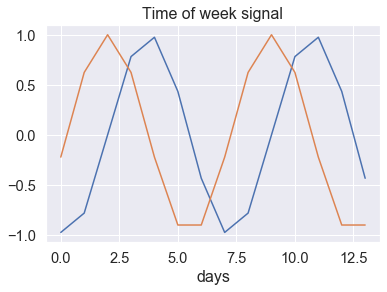

In [113]:
plt.plot(np.array(df_days['week_sin'])[:14])
plt.plot(np.array(df_days['week_cos'])[:14])
plt.xlabel('days')
plt.title('Time of week signal')

In [114]:
fft = tf.signal.rfft(df_days['pos'])
f_per_dataset = np.arange(0, len(fft))

In [115]:
df_days.shape

(434, 90)

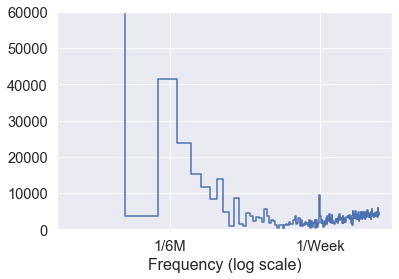

In [116]:
n_samples_day = len(df_days['pos'])
days_per_year = 365
years_per_dataset = n_samples_day/(days_per_year)
f_per_year = f_per_dataset/years_per_dataset

#nb_days_week
#weeks_per_dataset = n_samples_day/nb_days_week
#f_per_week = f_per_dataset/years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 60000)
plt.xlim([0.2, max(plt.xlim())])
plt.xticks([365/7, 365/(7*4*6)], labels=['1/Week', '1/6M'])
_ = plt.xlabel('Frequency (log scale)')

=> weekly periodicity

## Prepare features

In [15]:
dataset, data_std, data_mean = prepare_dataset_kr(df_feat_kr)
print(dataset)
print("data_mean : ", data_mean)
print("data_std : ", data_std)

[[-0.43842911 -0.03335956 -1.13417801 ... -0.54278014  0.99641704
  -0.36171153]
 [-0.43518827 -0.12215801 -1.30377381 ... -0.54175984  1.49462556
  -0.36171153]
 [-0.69121488 -0.47024795 -1.81069496 ... -0.78082929 -1.49462556
  -0.36171153]
 ...
 [ 0.80281383  1.15298779  0.21279056 ... -0.56624708 -1.49462556
  -0.45961863]
 [ 0.88059407  1.25954594 -0.1000402  ... -0.38112608 -0.99641704
  -0.61416822]
 [ 0.96161515  0.86883274  0.31473467 ...  1.03836875 -0.49820852
  -0.663525  ]]
data_mean :  [9.74274736e+00 1.91463977e+01 6.28461287e+01 1.83575408e+01
 2.47927954e+02 1.90186801e+04 3.00000000e+00 4.41442174e+01]
data_std :  [1.02853891e+01 9.38454775e+00 1.42888758e+01 6.26324047e+00
 3.18936079e+02 1.56816352e+04 2.00719168e+00 6.20951246e+00]


In [16]:
dataset.shape

(446, 8)

## Multi-step model

### Helper functions

In [17]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
    
def calculate_grad_max(x_train_multi, multi_step_model):
    '''
    Calculate absolute maximum of model gradients over training
    '''
    grad_final = 0
    for i_seq in range(x_train_multi.shape[0]):
        seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = multi_step_model(seq)
    
        grads = tape.gradient(predictions, seq)

        grad_min = abs(tf.reduce_min(grads).numpy())
        grad_max = abs(tf.reduce_max(grads).numpy())

        grad_curr = grad_min if grad_min > grad_max else grad_max

        grad_final = grad_curr if grad_curr > grad_final else grad_final
    
    return grad_final  

### data 14D_to_7D

In [18]:
TRAIN_SPLIT

347

In [19]:
dataset.shape

(446, 8)

In [20]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [21]:
y_train_multi.shape

(333, 7)

In [22]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

333 Single window of past history : (14, 8)

 333 Target temperature to predict : (7,)


In [23]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 333
nb samples for validation : 92


### Training

#### No Norm

In [34]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 333
BUFFER_SIZE : 347

For validation : 
BATCH_SIZE_VAL : 80



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01695: early stopping
Run #0 : val_loss = 0.6100567579269409


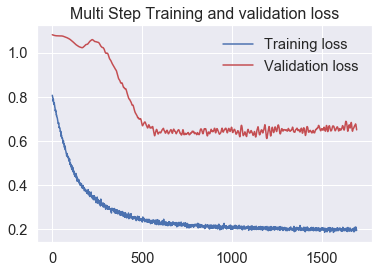

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01043: early stopping
Run #1 : val_loss = 0.49111175537109375


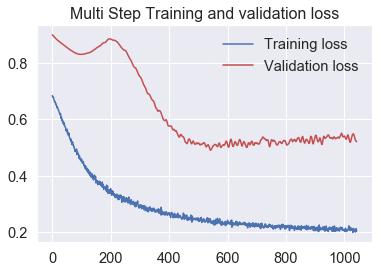

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02410: early stopping
Run #2 : val_loss = 0.5824769735336304

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 01336: early stopping
Run #3 : val_loss = 0.29741114377975464


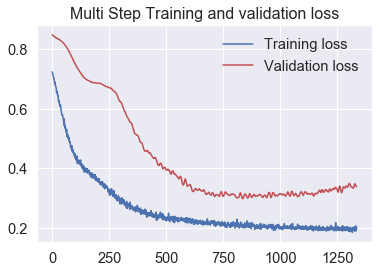

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01124: early stopping
Run #4 : val_loss = 0.32131630182266235

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01489: early stopping
Run #5 : val_loss = 0.4174441397190094

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 01013: early stopping
Run #6 : val_loss = 0.4820473790168762

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01200: early stopping
Run #7 : val_loss = 0.3977404236793518

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01292: early stopping
Run #8 : val_loss = 0.3611028790473938

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 01189: early stopping
Run #9 : val_loss = 0.4703660011291504
 
Final val_loss = 0.29741114377975464
Mean asbolute Error in people : 94.09550964360275
 
Wall time: 14min 6s


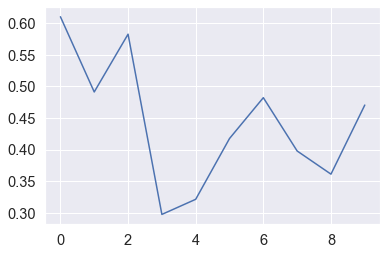

In [35]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    EVALUATION_INTERVAL = 1
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        #multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [36]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 2.2 s


In [37]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  50.46264339835957
Val. Mean Error  [nb of cases]:  94.09551092382384
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  16.110028315985556


#### BatchNorm


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01982: early stopping
Run #0 : val_loss = 0.45696401596069336


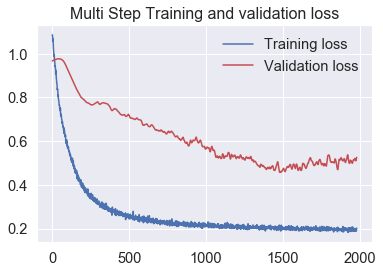

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00967: early stopping
Run #1 : val_loss = 0.5295591354370117

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01386: early stopping
Run #2 : val_loss = 0.30958110094070435


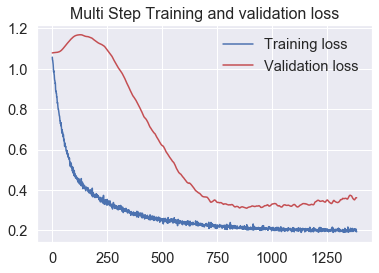

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #3
Restoring model weights from the end of the best epoch.
Epoch 01489: early stopping
Run #3 : val_loss = 0.6449706554412842

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01086: early stopping
Run #4 : val_loss = 0.9094500541687012

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01196: early stopping
Run #5 : val_loss = 0.4987289011478424

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 01544: early stopping
Run #6 : val_loss = 0.6656871438026428

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01923: early stopping
Run #7 : val_loss = 0.4635228216648102

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01381: early stopping
Run #8 : val_loss = 0.4816158413887024

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00501: early stopping
Run #9 : val_loss = 1.1622076034545898
 
Final val_loss = 0.30958110094070435
Mean asbolute Error in people : 97.94

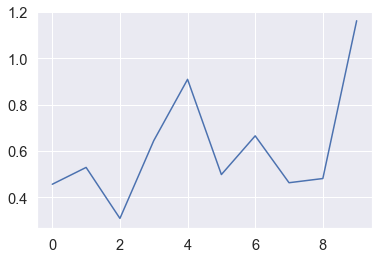

In [38]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    EVALUATION_INTERVAL = 1
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [39]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 2.1 s


In [40]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  56.126584883500925
Val. Mean Error  [nb of cases]:  97.94586987757035
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  16.76924564912466


#### LayerNorm


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01171: early stopping
Run #0 : val_loss = 0.38523703813552856


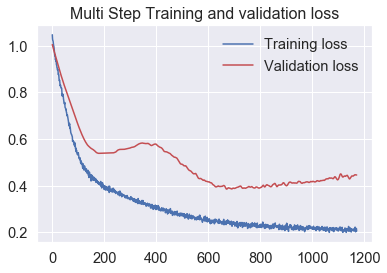

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 03918: early stopping
Run #1 : val_loss = 0.6845806837081909

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01512: early stopping
Run #2 : val_loss = 0.4438290596008301

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00995: early stopping
Run #3 : val_loss = 0.3500128984451294


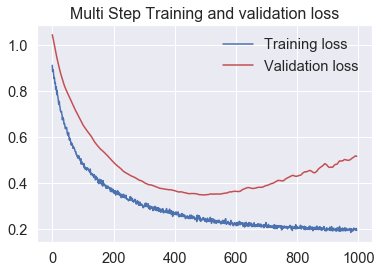

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #4
Restoring model weights from the end of the best epoch.
Epoch 01320: early stopping
Run #4 : val_loss = 0.29677873849868774


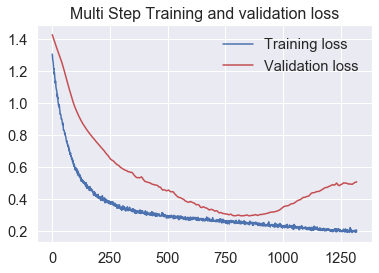

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #5
Restoring model weights from the end of the best epoch.
Epoch 01081: early stopping
Run #5 : val_loss = 0.4604492783546448

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00885: early stopping
Run #6 : val_loss = 0.34333452582359314

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 01325: early stopping
Run #7 : val_loss = 0.261804461479187


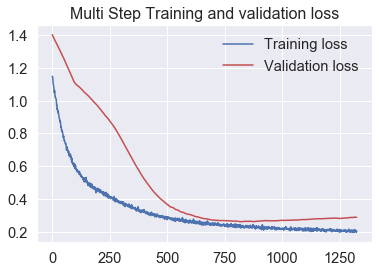

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01237: early stopping
Run #8 : val_loss = 0.4579508900642395

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 01984: early stopping
Run #9 : val_loss = 0.30826109647750854
 
Final val_loss = 0.261804461479187
Mean asbolute Error in people : 82.83019901936167
 
Wall time: 16min 27s


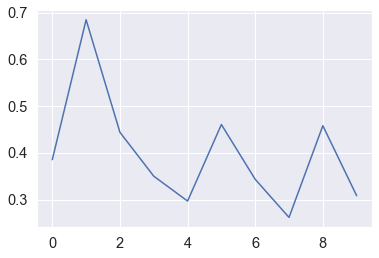

In [41]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    EVALUATION_INTERVAL = 1
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [46]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 2.15 s


In [47]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  58.92040737974993
Val. Mean Error  [nb of cases]:  82.83019660129915
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  14.181301526125482


#### No Norm / mini-batch  : Batch=32

In [24]:
BATCH_SIZE = 32
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = x_train_multi.shape[0]
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 32
BUFFER_SIZE : 333

For validation : 
BATCH_SIZE_VAL : 92


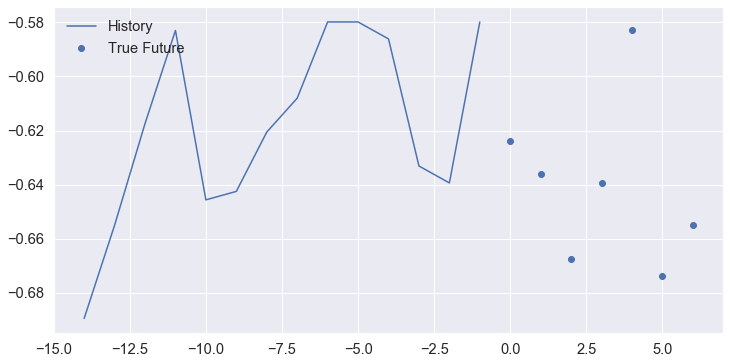

In [29]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00632: early stopping
Run #0 : val_loss = 0.4754701554775238


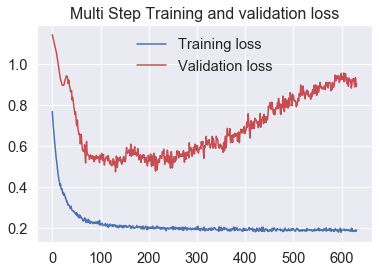

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00665: early stopping
Run #1 : val_loss = 0.3243395984172821


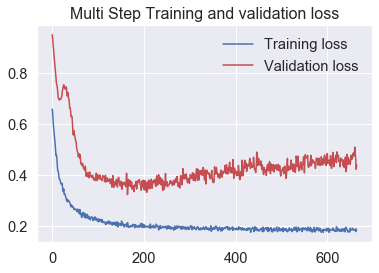

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01741: early stopping
Run #2 : val_loss = 0.24008913338184357


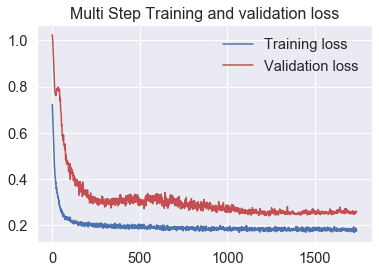

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00911: early stopping
Run #3 : val_loss = 0.2663204073905945

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00604: early stopping
Run #4 : val_loss = 0.3071669638156891

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00605: early stopping
Run #5 : val_loss = 0.3055974841117859

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00678: early stopping
Run #6 : val_loss = 0.26938682794570923

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00577: early stopping
Run #7 : val_loss = 0.47118544578552246

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 01886: early stopping
Run #8 : val_loss = 0.2562343180179596

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 01502: early stopping
Run #9 : val_loss = 0.2623918056488037
 
Final val_loss = 0.24008913338184357
Mean asbolute Error in people : 76.

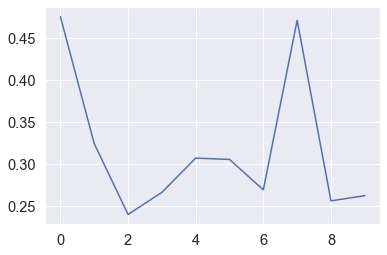

In [128]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    

    # Hyper-parameters
    
    # OLD : 
    # lr=2e-2: NB_TRY = 350 EPOCHS = 5000decay = 1e-6 #1e-6 momentum = 0.9  
    # nesterov = True  patience = 250
    #          Mean error  [nb of cases]:  100.51909796234426
    #          Mean nb cases  [nb of cases]:  996.6530612244898
    #          mean relative error [%]:  10.085665902520413
    # Wall time : 2h
    
    # NEW : 
    # Final val_loss = 0.2620798647403717
    # Mean error  [nb of cases]:  85.43251126273199
    # Mean nb cases  [nb of cases]:  648.3673469387755
    # mean relative error [%]:  13.17655981074557
    # Wall time: 4h 12min 6s (Mac)
    
    # No BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  88.7010976927777
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.186454502027152
    #Wall time: 17min 26s
    # BatchNormalization, Adam, NB_TRY = 10, EPOCHS = 10000, patience = 500
    #Mean error  [nb of cases]:  87.9794333988124
    #Mean nb cases  [nb of cases]:  584.0803571428571
    #mean relative error [%]:  15.062898849942659
    # val_loss = 1.1182507276535034
    # Wall time: 12min 55s
    # Hyper-parameters
    NB_TRY = 10 #350
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 #5000
    #lr = 2e-2 #2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    patience = 500 # 250

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        #multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [129]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 2.04 s


In [130]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  43.7594094219475
Val. Mean Error  [nb of cases]:  76.57308287276655
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  13.110025347768705


#### Layer Norm / mini-batch  : Batch=32


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00588: early stopping
Run #0 : val_loss = 0.26259881258010864


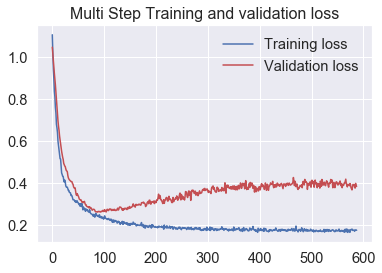

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00719: early stopping
Run #1 : val_loss = 0.3158334195613861

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00673: early stopping
Run #2 : val_loss = 0.2774111330509186

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00626: early stopping
Run #3 : val_loss = 0.2895996868610382

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00796: early stopping
Run #4 : val_loss = 0.3245718479156494

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00741: early stopping
Run #5 : val_loss = 0.2854282259941101

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00674: early stopping
Run #6 : val_loss = 0.3135201334953308

 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00609: early stopping
Run #7 : val_loss = 0.2756607234477997

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00583

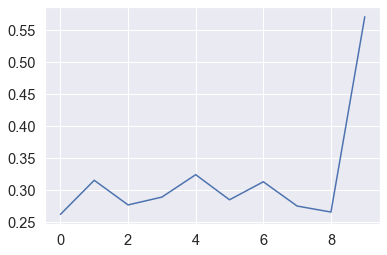

In [131]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 10
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 
    patience = 500 

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                        return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [132]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 2.08 s


In [133]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  64.72742269070626
Val. Mean Error  [nb of cases]:  83.75222348656216
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  14.33916112095474


#### Layer Norm / mini-batch 32 / drop 0.1


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00580: early stopping
Run #0 : val_loss = 0.42953211069107056


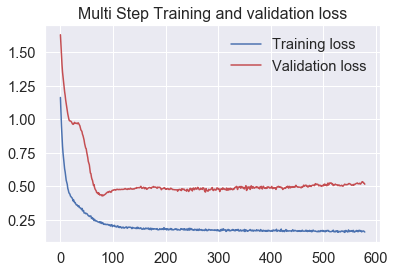

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00586: early stopping
Run #1 : val_loss = 0.34774476289749146


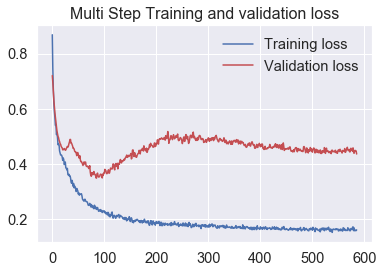

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00627: early stopping
Run #2 : val_loss = 0.4061788022518158
 
Final val_loss = 0.34774476289749146
Mean asbolute Error in people : 110.90835116431612
 
Wall time: 3min 57s


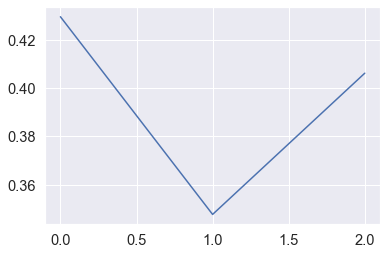

In [25]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 
    patience = 500 
    dropout_rate = 0.1
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                        return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [42]:
dropout_rate

0.1

In [26]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 2.55 s


In [27]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  61.86515901671131
Val. Mean Error  [nb of cases]:  110.90834659961962
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  18.98854245709433


In [31]:
x_train_multi.shape

(333, 14, 8)

In [34]:
x_train_multi[0].shape

(14, 8)

#### Evaluation Gradient max : 

In [54]:
calculate_grad_max(x_train_multi, multi_step_model)

2.8135571

#### Layer Norm / mini-batch 32 / drop 0.2 / gradient clip 2.85


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00576: early stopping
Run #0 : val_loss = 0.30891451239585876


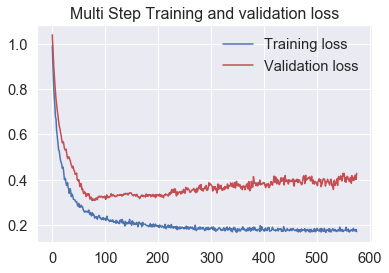

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01392: early stopping
Run #1 : val_loss = 0.2873055934906006


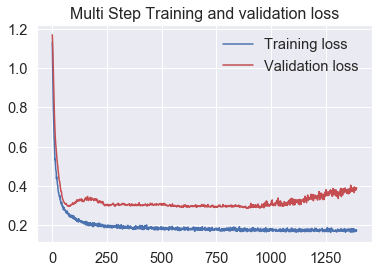

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets


INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01329: early stopping
Run #2 : val_loss = 0.4799882769584656
 
Final val_loss = 0.2873055934906006
Mean asbolute Error in people : 91.63211945688124
 
Wall time: 6min 45s


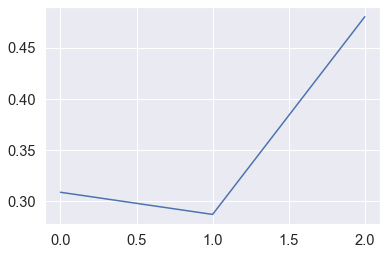

In [55]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 10000 
    patience = 500 
    dropout_rate = 0.2
    clipvalue = 2.85
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam(clipvalue=clipvalue)
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                        return_sequences=False,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [56]:
dropout_rate

0.2

In [57]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 2.11 s


In [58]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  50.885435637737835
Val. Mean Error  [nb of cases]:  91.63211670565808
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  15.688272270256517


#### Layer Norm / mini-batch 32 / drop recurrent 0.2 / gradient clip 2.85


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00182: early stopping
Run #0 : val_loss = 0.38812732696533203


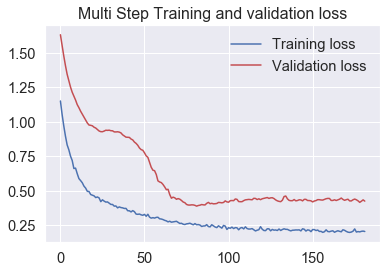

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00230: early stopping
Run #1 : val_loss = 0.3404274582862854


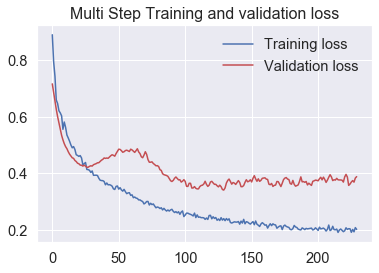

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
Run #2 : val_loss = 0.2985341548919678


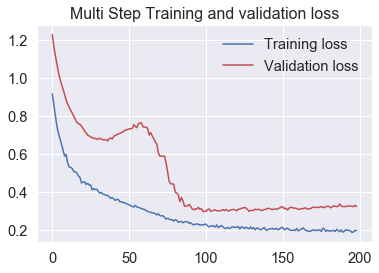

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets
 
Final val_loss = 0.2985341548919678
Mean asbolute Error in people : 95.2133128028182
 
Wall time: 17min 52s


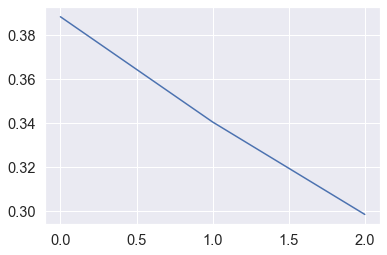

In [25]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 1000
    patience = 100 
    dropout_rate = 0.2
    dropout_recurrent_rate = 0.2
    clipvalue = 2.85
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam(clipvalue=clipvalue)
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                    return_sequences=False,
                                    recurrent_dropout=dropout_reccurent_rate,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [26]:
dropout_rate

0.2

In [ ]:
dropout_recurrent_rate

In [27]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 1.48 s


In [28]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  64.05971834294857
Val. Mean Error  [nb of cases]:  95.21331297778309
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  16.301406444061495


#### Layer Norm / mini-batch 32 / drop recurrent 0.4 / gradient clip 2.85


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00219: early stopping
Run #0 : val_loss = 0.26604390144348145


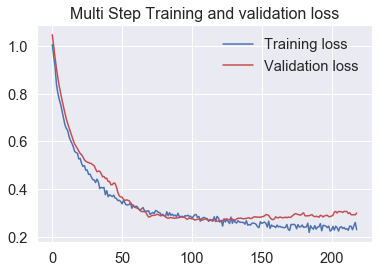

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00179: early stopping
Run #1 : val_loss = 0.27186867594718933

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00699: early stopping
Run #2 : val_loss = 0.2887553870677948

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00199: early stopping
Run #3 : val_loss = 0.27496570348739624

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00228: early stopping
Run #4 : val_loss = 0.24619492888450623


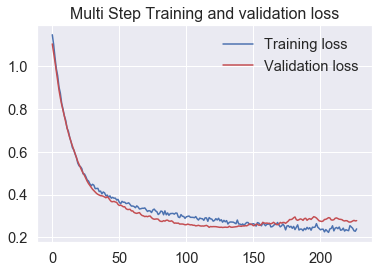

INFO:tensorflow:Assets written to: C:\Users\Shadow\Documents\CloudStation\Applications\python\CoronaVirus\code\coronavirusModel/mdl_multi_step_pos_kr\assets

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00189: early stopping
Run #5 : val_loss = 0.29103249311447144
 
Final val_loss = 0.24619492888450623
Mean asbolute Error in people : 78.52044528315633
 
Wall time: 44min 6s


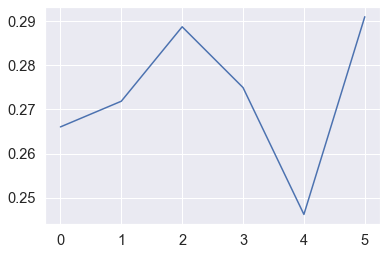

In [32]:
%%time
# Train Mean Error  [nb of cases]:  79.68283553387589
#Val. Mean Error  [nb of cases]:  77.00942832890918
#Val. Mean nb cases  [nb of cases]:  584.0803571428571
#Val. Mean Relative Error [%]:  13.184731756023401
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 6
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    EPOCHS = 1000
    patience = 100 
    dropout_rate = 0.4
    dropout_recurrent_rate = 0.4
    clipvalue = 2.85
    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        optim = tf.optimizers.Adam(clipvalue=clipvalue)
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(x_train_multi.shape[-1], 
                                    return_sequences=False,
                                    recurrent_dropout=dropout_recurrent_rate,
                                        input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
        multi_step_model.add(tf.keras.layers.LayerNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [33]:
dropout_rate

0.4

In [34]:
dropout_recurrent_rate

0.4

In [35]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

Wall time: 1.3 s


In [36]:
y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  77.05194326691266
Val. Mean Error  [nb of cases]:  78.52044232013904
Val. Mean nb cases  [nb of cases]:  584.0803571428571
Val. Mean Relative Error [%]:  13.443431431975744


### Eval

In [26]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 1.84 s, sys: 150 ms, total: 1.99 s
Wall time: 2.33 s


In [27]:
#Layer Norm / mini-batch 32 / drop & recurrent 0.4 / gradient clip 2.85
#Train Mean Error  [nb of cases]:  77.05194326691266
#Val. Mean Error  [nb of cases]:  78.52044232013904
#Val. Mean nb cases  [nb of cases]:  584.0803571428571
#Val. Mean Relative Error [%]:  13.443431431975744


y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  77.05194318332052
Val. Mean Error  [nb of cases]:  76.8802336356497
Val. Mean nb cases  [nb of cases]:  574.6739130434783
Val. Mean Relative Error [%]:  13.378062217665542


In [26]:
multi_step_model.predict(x_val_multi)

array([[0.9503009 , 0.9750676 , 0.9658571 , 0.99563026, 0.8868964 ,
        0.9144638 , 0.89755684],
       [0.906212  , 0.97000194, 0.92622924, 0.95955026, 0.80154383,
        0.8304307 , 0.80736864],
       [0.8899293 , 0.9373778 , 0.9070477 , 0.9416604 , 0.8009094 ,
        0.8300584 , 0.81305456],
       [0.7636056 , 0.78302884, 0.7604861 , 0.7963182 , 0.69456685,
        0.70119905, 0.6741914 ],
       [0.70808494, 0.68700004, 0.6953556 , 0.73292816, 0.67893696,
        0.68156916, 0.665827  ],
       [0.67245436, 0.5875255 , 0.6445267 , 0.67909956, 0.7081753 ,
        0.6967067 , 0.68776226],
       [0.7763892 , 0.75000346, 0.7650985 , 0.78583443, 0.7690175 ,
        0.7585891 , 0.74014354],
       [0.83501345, 0.85602224, 0.84510523, 0.8576313 , 0.7901446 ,
        0.793985  , 0.7832549 ],
       [0.7198622 , 0.7740657 , 0.72924167, 0.7703508 , 0.6276169 ,
        0.64263207, 0.6215368 ],
       [0.72233534, 0.7580986 , 0.7273428 , 0.77206063, 0.6465513 ,
        0.66031843, 0.6

In [26]:
y_val_multi_pred.shape[0]

80

In [30]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 8), (None, 7)), types: (tf.float64, tf.float64)>

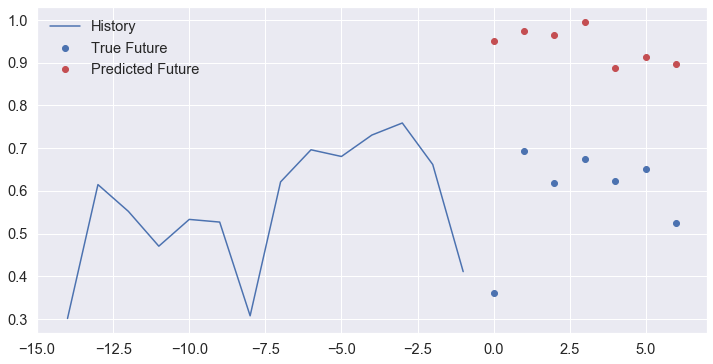

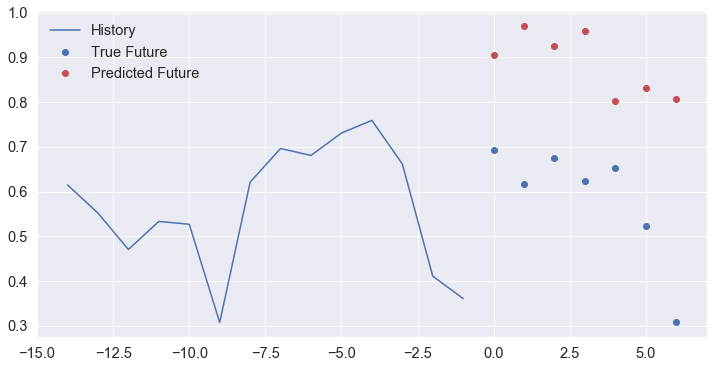

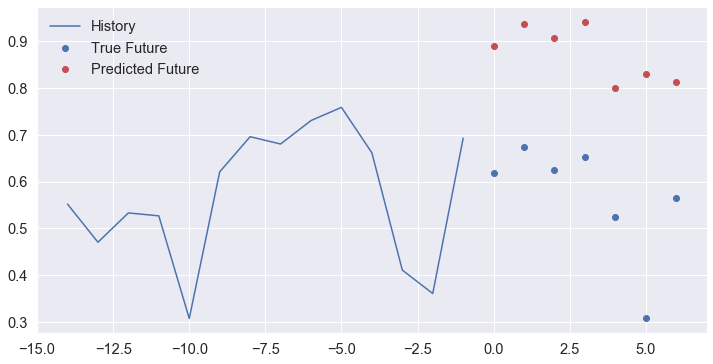

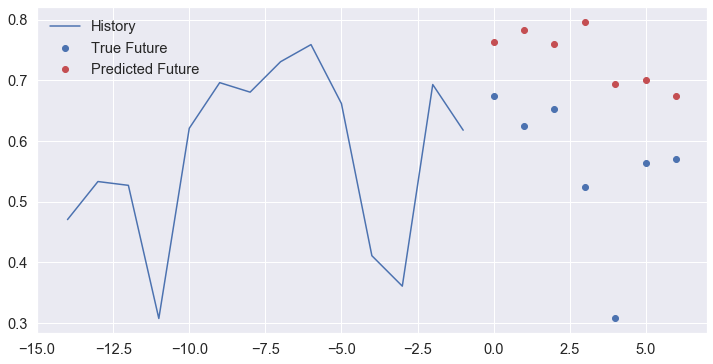

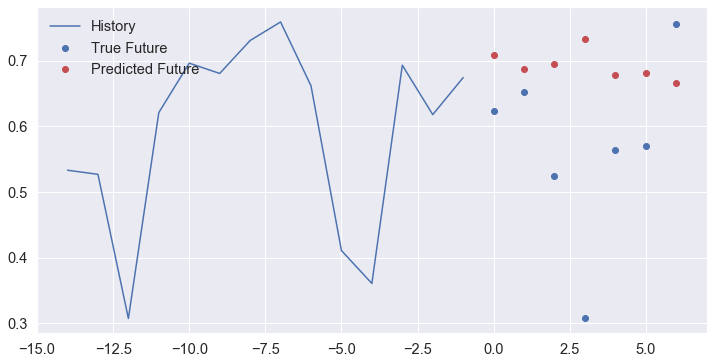

In [31]:
for x, y in val_data_multi.take(1):
    for I in range(5):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [32]:
nb_period_plot = 9 #23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [33]:
PATH_MDL_MULTI_STEP_KR

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr'

In [34]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

In [35]:
TRAIN_SPLIT

347

In [36]:
'''# reload data
df_feat_kr = load_df_feat_kr()
# clean data
df_feat_kr = prepare_data_features_kr(df_feat_kr)
# prepare features
dataset, data_std, data_mean = prepare_dataset_kr(features)'''

'# reload data\ndf_feat_kr = load_df_feat_kr()\n# clean data\ndf_feat_kr = prepare_data_features_kr(df_feat_kr)\n# prepare features\ndataset, data_std, data_mean = prepare_dataset_kr(features)'

In [37]:
df_feat_kr.shape

(434, 88)

In [38]:
dataset.shape

(434, 8)

In [39]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 283 ms, sys: 12.5 ms, total: 296 ms
Wall time: 303 ms


In [40]:
df_feat_kr.date.min()

'2020-04-03'

In [41]:
df_feat_kr.date.max()

'2021-06-10'

In [42]:
df_feat_kr.pos.std()

318.2480586049229

In [43]:
data_std

array([1.02853891e+01, 9.38454775e+00, 1.42888758e+01, 6.26324047e+00,
       3.18936079e+02, 1.56816352e+04, 2.00719168e+00, 6.20951246e+00])

In [44]:
data_std[4]

318.93607897988613

In [45]:
str_date_0 = add_days(df_feat_kr.date.max(), -NB_DAY_PLOT)
str_date_0

'2021-04-08'

In [46]:
# last nth days
df_plot = df_feat_kr[df_feat_kr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_kr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date  pos  nb_cases
2021-06-11  2021-06-11  526  146829.0
2021-06-12  2021-06-12  562  147391.0
2021-06-13  2021-06-13  545  147936.0
2021-06-14  2021-06-14  552  148488.0
2021-06-15  2021-06-15  467  148955.0
2021-06-16  2021-06-16  503  149458.0
2021-06-17  2021-06-17  504  149962.0

In [47]:
df_feat_kr

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-04-03   10062.0   424365.0      174.0  2020-04-03      5.0   0.0   
2020-04-04   10156.0   434888.0      177.0  2020-04-04      6.0   0.0   
2020-04-05   10237.0   441662.0      183.0  2020-04-05      0.0   3.0   
2020-04-06   10284.0   447509.0      186.0  2020-04-06      1.0   0.0   
2020-04-07   10331.0   456654.0      192.0  2020-04-07      2.0   0.0   
...              ...        ...        ...         ...      ...   ...   
2021-06-06  144152.0  9823232.0     1973.0  2021-06-06      0.0  19.0   
2021-06-07  144637.0  9835771.0     1974.0  2021-06-07      1.0  13.0   
2021-06-08  145090.0  9869323.0     1975.0  2021-06-08      2.0   8.0   
2021-06-09  145692.0  9913359.0     1977.0  2021-06-09      3.0   7.0   
2021-06-10  146303.0  9946535.0     1979.0  2021-06-10      4.0  10.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2020-04-03        1.0        5.0      1.0      1.0  ...    5.000000   
2020-04-04        1.0        1.0      0.0      0.0  ...    5.000000   
2020-04-05        1.0        4.0      0.0      1.0  ...    6.000000   
2020-04-06        2.0        2.0      0.0      0.0  ...    6.000000   
2020-04-07        1.0        1.0      0.0      0.0  ...    6.000000   
...               ...        ...      ...      ...  ...         ...   
2021-06-06       17.0       10.0      9.0      0.0  ...    0.554217   
2021-06-07       28.0        9.0      3.0      3.0  ...    0.565217   
2021-06-08       48.0        7.0      8.0      4.0  ...    0.584416   
2021-06-09       39.0       13.0      6.0      6.0  ...    0.652174   
2021-06-10       33.0       11.0      4.0      2.0  ...    0.641791   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2020-04-03         10.0         inf          106.0      4.240000   
2020-04-04         10.0         inf           67.0      1.030769   
2020-04-05          9.0    9.000000           60.0      0.789474   
2020-04-06          9.0    9.000000           60.0      0.769231   
2020-04-07          9.0    9.000000           60.0      0.759494   
...                 ...         ...            ...           ...   
2021-06-06        128.0    0.558952          162.0      0.589091   
2021-06-07        117.0    0.500000          159.0      0.593284   
2021-06-08        118.0    0.510823          154.0      0.581132   
2021-06-09        113.0    0.502222          158.0      0.591760   
2021-06-10        101.0    0.441048          157.0      0.613281   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2020-04-03           20.0     20.000000       5.0       inf   True  
2020-04-04           21.0     21.000000       5.0       inf   True  
2020-04-05           21.0     10.500000       8.0       inf   True  
2020-04-06           22.0      7.333333       8.0       inf   True  
2020-04-07           22.0      5.500000       8.0       inf   True  
...                   ...           ...       ...       ...    ...  
2021-06-06          269.0      0.838006     203.0  1.362416  False  
2021-06-07          280.0      0.869565     197.0  1.279221  False  
2021-06-08          314.0      0.963190     188.0  1.278912  False  
2021-06-09          333.0      1.009091     189.0  1.350000  False  
2021-06-10          348.0      1.101266     173.0  1.101911  False  

[434 rows x 88 columns]

In [48]:
df_feat_kr.iloc[TRAIN_SPLIT]["date"]

'2021-03-16'

In [49]:
df_plot

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2021-04-08  107592.0  7934421.0     1758.0  2021-04-08      4.0   5.0   
2021-04-09  108263.0  7977195.0     1764.0  2021-04-09      5.0   2.0   
2021-04-10  108940.0  8016611.0     1765.0  2021-04-10      6.0   7.0   
2021-04-11  109554.0  8037618.0     1768.0  2021-04-11      0.0   7.0   
2021-04-12  110141.0  8057530.0     1770.0  2021-04-12      1.0   3.0   
...              ...        ...        ...         ...      ...   ...   
2021-06-06  144152.0  9823232.0     1973.0  2021-06-06      0.0  19.0   
2021-06-07  144637.0  9835771.0     1974.0  2021-06-07      1.0  13.0   
2021-06-08  145090.0  9869323.0     1975.0  2021-06-08      2.0   8.0   
2021-06-09  145692.0  9913359.0     1977.0  2021-06-09      3.0   7.0   
2021-06-10  146303.0  9946535.0     1979.0  2021-06-10      4.0  10.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2021-04-08       11.0       11.0      1.0     24.0  ...    1.779528   
2021-04-09       15.0        7.0     11.0     22.0  ...    1.944444   
2021-04-10       46.0       26.0      7.0     23.0  ...    2.038760   
2021-04-11       16.0       13.0      6.0     40.0  ...    2.346457   
2021-04-12       17.0       15.0      3.0     24.0  ...    2.415385   
...               ...        ...      ...      ...  ...         ...   
2021-06-06       17.0       10.0      9.0      0.0  ...    0.554217   
2021-06-07       28.0        9.0      3.0      3.0  ...    0.565217   
2021-06-08       48.0        7.0      8.0      4.0  ...    0.584416   
2021-06-09       39.0       13.0      6.0      6.0  ...    0.652174   
2021-06-10       33.0       11.0      4.0      2.0  ...    0.641791   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2021-04-08         36.0    2.769231          180.0      1.487603   
2021-04-09         45.0    4.090909          174.0      1.392000   
2021-04-10         52.0    5.200000          189.0      1.549180   
2021-04-11         57.0    6.333333          195.0      1.625000   
2021-04-12         59.0    6.555556          207.0      1.725000   
...                 ...         ...            ...           ...   
2021-06-06        128.0    0.558952          162.0      0.589091   
2021-06-07        117.0    0.500000          159.0      0.593284   
2021-06-08        118.0    0.510823          154.0      0.581132   
2021-06-09        113.0    0.502222          158.0      0.591760   
2021-06-10        101.0    0.441048          157.0      0.613281   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2021-04-08          263.0      0.440536      27.0  1.800000  False  
2021-04-09          241.0      0.416955      26.0  1.625000  False  
2021-04-10          268.0      0.500935      31.0  1.823529  False  
2021-04-11          271.0      0.547475      38.0  2.375000  False  
2021-04-12          268.0      0.553719      40.0  2.857143  False  
...                   ...           ...       ...       ...    ...  
2021-06-06          269.0      0.838006     203.0  1.362416  False  
2021-06-07          280.0      0.869565     197.0  1.279221  False  
2021-06-08          314.0      0.963190     188.0  1.278912  False  
2021-06-09          333.0      1.009091     189.0  1.350000  False  
2021-06-10          348.0      1.101266     173.0  1.101911  False  

[64 rows x 88 columns]

### Figure

In [50]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_kr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [51]:
nb_period_plot

9

In [52]:
19*7

133

In [53]:
179-4*7

151

In [54]:
dataset.shape

(434, 8)

In [55]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[357 - 371]
[364 - 378]
[371 - 385]
[378 - 392]
[385 - 399]
[392 - 406]
[399 - 413]
[406 - 420]
[413 - 427]
9
CPU times: user 407 ms, sys: 29.5 ms, total: 437 ms
Wall time: 424 ms


array([[613.6644 , 648.78076, 630.8229 , 640.5824 , 560.076  , 589.45905,
        589.4885 , 599.4492 , 622.3203 , 612.393  , 620.29285, 561.33026,
        582.824  , 582.336  , 700.3687 , 762.6068 , 734.11414, 737.3379 ,
        617.61523, 671.828  , 679.07764, 663.67224, 719.06104, 692.5442 ,
        695.2577 , 587.1393 , 633.1209 , 638.65125, 616.40076, 664.9818 ,
        638.49927, 644.74646, 545.38464, 581.7986 , 582.6671 , 651.83386,
        704.9096 , 680.4376 , 685.52637, 574.2683 , 624.26697, 629.7843 ,
        595.51013, 612.8972 , 610.70374, 616.7048 , 554.61865, 588.5552 ,
        591.2001 , 594.70044, 629.8554 , 613.10626, 618.7514 , 535.37354,
        570.31244, 570.8958 , 569.1732 , 584.3329 , 581.26025, 588.7269 ,
        530.13   , 559.1876 , 559.6262 ]], dtype=float32)

In [56]:
y_pos_pred.shape

(1, 63)

In [57]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_kr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_kr[df_feat_kr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2021-04-08
2021-06-10


date  pos  nb_cases
2021-04-09  2021-04-09  613  108205.0
2021-04-10  2021-04-10  648  108853.0
2021-04-11  2021-04-11  630  109483.0
2021-04-12  2021-04-12  640  110123.0
2021-04-13  2021-04-13  560  110683.0
...                ...  ...       ...
2021-06-06  2021-06-06  581  143891.0
2021-06-07  2021-06-07  588  144479.0
2021-06-08  2021-06-08  530  145009.0
2021-06-09  2021-06-09  559  145568.0
2021-06-10  2021-06-10  559  146127.0

[63 rows x 3 columns]

### Figure all past 

In [58]:
str_date_mdl =  df_feat_kr.iloc[TRAIN_SPLIT]["date"]

In [59]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [60]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()

### Features importance

In [30]:
list_feat = ['T_min', 'T_max', 'H_mean','W_speed', 'pos', 'test', 'day_num',
                                           'age_pos']

In [34]:

arr_grads = None
for i_seq in range(x_train_multi.shape[0]):
    seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = multi_step_model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    if arr_grads is None:
        arr_grads = grads
    arr_grads = np.vstack((arr_grads,grads))
arr_grads

array([[ 2.48058848e-02, -2.29327809e-02, -2.98105516e-02, ...,
        -3.72056849e-02,  4.59631643e-04,  1.37247015e-02],
       [ 2.48058848e-02, -2.29327809e-02, -2.98105516e-02, ...,
        -3.72056849e-02,  4.59631643e-04,  1.37247015e-02],
       [ 2.06252243e-02, -2.65478902e-02, -2.36116182e-02, ...,
        -2.34824680e-02,  3.17687495e-03,  9.80836994e-05],
       ...,
       [ 7.77571872e-02, -4.22866419e-02, -7.62712359e-02, ...,
        -9.51341018e-02, -2.47621853e-02, -1.35532196e-03],
       [ 7.47464895e-02, -3.86421271e-02, -6.95023909e-02, ...,
        -8.87348428e-02, -2.25174464e-02, -4.04556561e-03],
       [ 8.85196105e-02, -3.09118927e-02, -7.92665631e-02, ...,
        -9.95954871e-02, -2.01133452e-02, -4.29188507e-03]], dtype=float32)

In [36]:
df_grads = pd.DataFrame(data=arr_grads, columns=list_feat)
df_grads

T_min     T_max    H_mean   W_speed       pos      test   day_num  \
0    0.024806 -0.022933 -0.029811 -0.045245  0.095453 -0.037206  0.000460   
1    0.024806 -0.022933 -0.029811 -0.045245  0.095453 -0.037206  0.000460   
2    0.020625 -0.026548 -0.023612 -0.039006  0.057959 -0.023482  0.003177   
3    0.018228 -0.019716 -0.023471 -0.037159  0.057377 -0.029847  0.010090   
4    0.007709 -0.020056 -0.019974 -0.031129  0.038963 -0.016899 -0.006565   
..        ...       ...       ...       ...       ...       ...       ...   
329  0.080627 -0.041899 -0.076954 -0.122226  0.269169 -0.111774 -0.010381   
330  0.084092 -0.031789 -0.071843 -0.103784  0.248266 -0.105069 -0.009897   
331  0.077757 -0.042287 -0.076271 -0.113511  0.254218 -0.095134 -0.024762   
332  0.074746 -0.038642 -0.069502 -0.104365  0.242453 -0.088735 -0.022517   
333  0.088520 -0.030912 -0.079267 -0.100390  0.244876 -0.099595 -0.020113   

      age_pos  
0    0.013725  
1    0.013725  
2    0.000098  
3    0.003622  
4    0.013376  
..        ...  
329 -0.000294  
330 -0.004358  
331 -0.001355  
332 -0.004046  
333 -0.004292  

[334 rows x 8 columns]

(-0.6, 0.6)

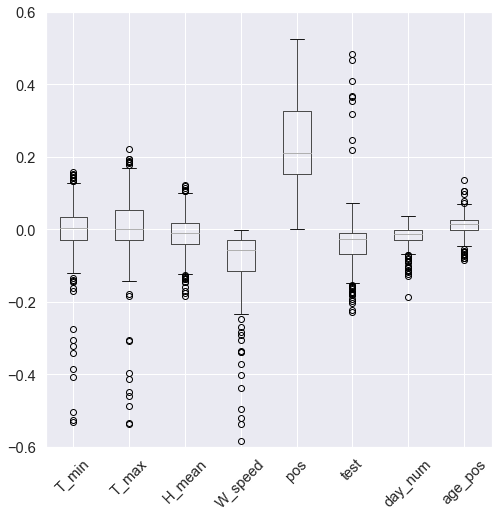

In [42]:
fig = plt.figure(figsize=(8, 8))
boxplot = df_grads.boxplot(rot=45)
ax = fig.gca()
ax.set_ylim([-0.6, 0.6])